In this notebook, we will make an interpolation grid that will be used to interpolate 3D fields from the ECCO-Darwin model for use as initial conditions. 

In this notebook, we will also confront two new challenges that were not seen in the previous model examples. First, the regional model grid has different depth levels compared to the ECCO grid, so we will also need to interpolate the variables vertically. Second, the grid is at very high latitude, which means we will need to reproject the fields to an appropriate coordinate system before interpolation. 

First, import packages to visualize the model fields here:

In [1]:
# import modules for computation and plotting
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

# import pertinent tools from eccoseas
from eccoseas.ecco import pickup
from eccoseas.ecco import grid
from eccoseas.ecco import io
from eccoseas.downscale import horizontal
from eccoseas.downscale import vertical
from eccoseas.toolbox import reprojection
from eccoseas.downscale import interpolation_grid as ecco_interp

## Motivation for an Interpolation Grid
For this model, we will use pickup files from the ECCO-Darwin model to construct our initial conditions. In total, we will need to interpolate separate fields: 11 baseline physical variable, 5 sea ice variables, and 37 variable pertaining to the biogeochemistry. Given that the interpolation can be quite slow, especially in areas with a complex coastline that was not represented in the global model, it is advantangeous to first make and store a grid that identifies when and how the interpolation is completed. In other words, we can keep track of where the grid has been interpolated with bilinear interpolation, and locations where a "spreading" routine is used to fill adjacent cells.

## Constructing the Interpolation Grid

To construct the interpolation grid, we will proceed in the following steps:
1. ensure we have downloaded the necessary ECCO grid files
2. read in the ECCO model grid
3. read in grid for the regional domain
4. prepare the ECCO fields for interpolation
5. interpolate the masks vertically
6. rerproject the model grid
7. create and store the interpolation grid
8. visualize the results

### Step 1: Download the ECCO Files
To begin, ensure that all of the necessary pickup and grid files are obtained for this configuration. These are listed on the Overview page for this model. 

These files are stored in the following directory:

In [2]:
data_folder = '../../../data/alaskan_north_slope'

### Step 2: Read in the ECCO grid

Next, we will read in the ECCO grid and convert the grid to tiles. This can be done with functions from the `io` and `grid` modules of **eccoseas**:

In [3]:
ecco_XC_faces, ecco_YC_faces, ecco_AngleCS_faces, ecco_AngleSN_faces, ecco_hFacC_faces, ecco_hFacW_faces, ecco_hFacS_faces =\
     io.read_ecco_geometry_to_faces(data_folder, llc=270, Nr=50)

In [4]:
ecco_XC_tiles = grid.ecco_faces_to_tiles(ecco_XC_faces, llc=270, dim=2)
ecco_YC_tiles = grid.ecco_faces_to_tiles(ecco_YC_faces, llc=270, dim=2)
ecco_AngleCS_tiles = grid.ecco_faces_to_tiles(ecco_AngleCS_faces, llc=270, dim=2)
ecco_AngleSN_tiles = grid.ecco_faces_to_tiles(ecco_AngleSN_faces, llc=270, dim=2)
ecco_hFacC_tiles = grid.ecco_faces_to_tiles(ecco_hFacC_faces, llc=270, dim=3)
ecco_hFacS_tiles = grid.ecco_faces_to_tiles(ecco_hFacS_faces, llc=270, dim=3)
ecco_hFacW_tiles = grid.ecco_faces_to_tiles(ecco_hFacW_faces, llc=270, dim=3)
ecco_RF = np.fromfile(os.path.join(data_folder,'RF.data'), '>f4')
ecco_DRF = np.fromfile(os.path.join(data_folder,'DRF.data'), '>f4')

In [5]:
ecco_Nr = np.size(ecco_DRF)

### Step 3: Read in the Regional Model Grid and Mask
Since the model grid has already been generated for this model (see note on the Model Grid page for this model), we will read it in from the nc file:

In [6]:
# define the parameters that will be used in the data file
ds = nc4.Dataset('../../../data/alaskan_north_slope/NorthSlope_ncgrid.nc')
XC = ds.variables['XC'][:, :]
YC = ds.variables['YC'][:, :]
bathy = -1*ds.variables['Depth'][:,:]
AngleCS = ds.variables['AngleCS'][:,:]
AngleSN = ds.variables['AngleSN'][:,:]
hFacC = ds.variables['HFacC'][:, :, :]
hFacW = ds.variables['HFacW'][:, :, :]
hFacS = ds.variables['HFacS'][:, :, :]
delR = ds.variables['drF'][:]
ds.close()
Z = np.cumsum(delR)

# remove the extra row and col from hFacS and hFacW
hFacS = hFacS[:,:-1,:]
hFacW = hFacW[:,:,:-1]

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [7]:
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. By assessing the ECCO grid geometry, we discover that we need tiles 7 and 8:

In [8]:
# define the tile list
tile_list = [7,8]

Let's verify that these tiles cover our grid:

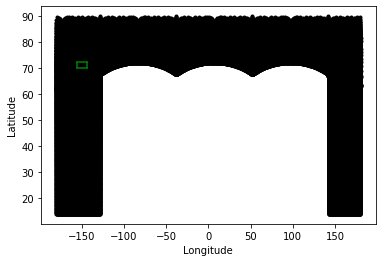

In [9]:
# plot the ECCO tile points
for tile in tile_list:
    plt.plot(ecco_XC_tiles[tile],ecco_YC_tiles[tile],'k.')

# plot the boundary of the regional model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, this model boundary (green) is completely surrounded by the points in tile 7 and 8 (black). We also note that there is a lot extraneous information in points outside the regional of our model domain - we will omit these points to speed up our interpolation. Given these observations, now I read in points from just those tiles to use in interpolation:

In [10]:
# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_AngleCS_points = np.zeros((total_points, ))
ecco_AngleSN_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((ecco_Nr, total_points))
ecco_maskW_points = np.zeros((ecco_Nr, total_points))
ecco_maskS_points = np.zeros((ecco_Nr, total_points))
ecco_hFacW_points = np.zeros((ecco_Nr, total_points))
ecco_hFacS_points = np.zeros((ecco_Nr, total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()

    ecco_AngleCS_points[points_counted:points_counted+tile_N] = ecco_AngleCS_tiles[tile_number].ravel()
    ecco_AngleSN_points[points_counted:points_counted+tile_N] = ecco_AngleSN_tiles[tile_number].ravel()
    
    for k in range(ecco_Nr):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

# remove the points outside the immediate area
local_indices = (ecco_XC_points<-140) & (ecco_XC_points>-160) & (ecco_YC_points>65) & (ecco_YC_points<80)
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

We can double check we have selected the right points by recreating the same plot above:

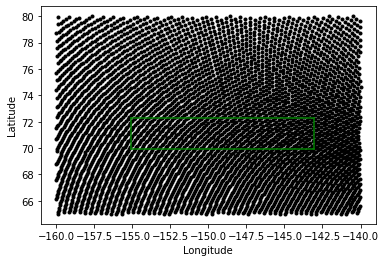

In [11]:
# plot the ECCO tile points
plt.plot(ecco_XC_points,ecco_YC_points,'k.')

# plot the boundary of the regional model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Step 5: Interpolate the ECCO mask vertically

Next, we will address the differences in the vertical grid layers. We can see that they are different by checking their length:

In [12]:
print('Depth levels in the ECCO grid:',str(np.shape(ecco_DRF)[0]))
print('Depth levels in the regional model grid:',str(np.shape(delR)[0]))

Depth levels in the ECCO grid: 50
Depth levels in the regional model grid: 81


And also by plotting these fields vertically:

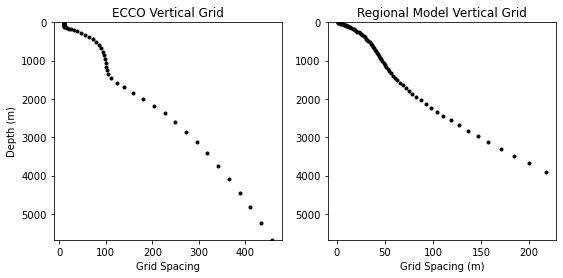

In [13]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(ecco_DRF, -1*ecco_RF[:-1], 'k.')
plt.gca().set_ylim([np.max(-1*ecco_RF[:-1]), 0])
plt.title('ECCO Vertical Grid')
plt.ylabel('Depth (m)')
plt.xlabel('Grid Spacing')

plt.subplot(1,2,2)
plt.plot(delR, Z, 'k.')  
plt.gca().set_ylim([np.max(-1*ecco_RF[:-1]), 0])
plt.title('Regional Model Vertical Grid')
plt.xlabel('Grid Spacing (m)')

plt.show()

To address these differences, we can use the `vertical` module of the **eccoseas** package to interpolate the ECCO mask onto the same vertical grid levels as the regional mask:

In [14]:
_, ecco_maskC_points_extended = \
    vertical.interpolate_var_grid_faces_to_new_depth_levels(ecco_maskC_points, ecco_maskC_points,
                                                            np.array(ecco_DRF), np.array(delR))

Let's take a look at the new mask relative to the old one:

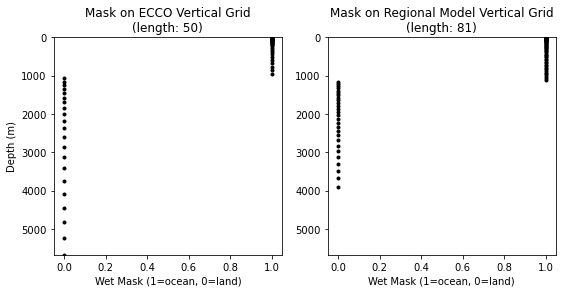

In [15]:
fig = plt.figure(figsize=(9,4))
random_plot_index = 117

plt.subplot(1,2,1)
plt.plot(ecco_maskC_points[:,random_plot_index], -1*ecco_RF[:-1], 'k.')
plt.gca().set_ylim([np.max(-1*ecco_RF[:-1]), 0])
plt.title('Mask on ECCO Vertical Grid\n(length: '+str(np.size(ecco_maskC_points[:,random_plot_index]))+')')
plt.ylabel('Depth (m)')
plt.xlabel('Wet Mask (1=ocean, 0=land)')

plt.subplot(1,2,2)
plt.plot(ecco_maskC_points_extended[:,random_plot_index], Z, 'k.')  
plt.gca().set_ylim([np.max(-1*ecco_RF[:-1]), 0])
plt.title('Mask on Regional Model Vertical Grid\n(length: '+str(np.size(ecco_maskC_points_extended[:,random_plot_index]))+')')
plt.xlabel('Wet Mask (1=ocean, 0=land)')

plt.show()

Now that our masks are on the same grid levels, we are almost ready to make our interpolation grid.

### Step 6: Reprojecting the Model Grid

Given the location of this model at high latitude, we are going to run into some curious interpolation artefacts if bilinear interpolation is performed using longitude and latitude as coordinates. To demonstrate this issue, let's read in the `Theta` grid from the pickup file and try to interpolate it without reprojecting:

In [16]:
# read in the global pickup file
global_pickup_faces, global_pickup_metadata = \
    pickup.read_ecco_pickup_file_to_faces(os.path.join(data_folder,'pickup.0000000001'), llc=270)

# convert to tiles
theta_faces = global_pickup_faces['Theta']
theta_tiles = grid.ecco_faces_to_tiles(theta_faces, llc=270, dim=3)

# preprocess like the grid fields
N = np.shape(theta_tiles[1])[-1]*np.shape(theta_tiles[1])[-2]
theta_grid = np.zeros((ecco_Nr, N*len(tile_list)))
points_counted = 0
for tile_number in tile_list:
    for k in range(ecco_Nr):
        theta_grid[k,points_counted:points_counted+N] = \
             theta_tiles[tile_number][k, :, :].ravel()
    points_counted += N
theta_grid = theta_grid[:,local_indices]

In [17]:
interpolated_theta = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                    theta_grid, ecco_maskC_points_extended, 
                                                    XC, YC, maskC, testing=True, printing=True,
                                                    use_legacy=True, verbose=True)

    Working on level 0 of 50 (338562 nonzero points found)


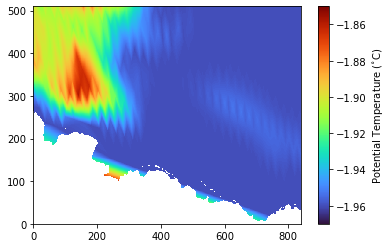

In [18]:
plot_grid = np.ma.masked_where(interpolated_theta[0,:,:]==0, interpolated_theta[0,:,:])
C = plt.pcolormesh(plot_grid,vmin=-1.97, vmax=-1.85, cmap='turbo')
plt.colorbar(C, label='Potential Temperature ($^{\circ}$C)')
plt.show()

Here, we see two problems - first, the interpolation has produced a lot of triangular artefacts resulting from using longitude and latitude as coordinates. We also see some issue with values near the coastline resulting from differing coastlines in the models.

First, let's try reprojecting coordinates to that distances are computed more appropriately for the location. We can do this with the `reprojection` model provided with **eccoseas**:

In [19]:
utm_zone_epsg = 32606
utm_coordinates = reprojection.reproject_polygon(np.column_stack([ecco_XC_points, ecco_YC_points]), 4326, utm_zone_epsg)

regional_coordinates = reprojection.reproject_polygon(np.column_stack([XC.ravel(), YC.ravel()]), 4326, utm_zone_epsg)
X = regional_coordinates[:,0].reshape(np.shape(XC))
Y = regional_coordinates[:,1].reshape(np.shape(XC))

When using these coordinates, the triangular artefacts are alleviated:

In [20]:
interpolated_theta = horizontal.downscale_3D_points(utm_coordinates,
                                                   theta_grid, ecco_maskC_points, 
                                                   X, Y, maskC, 
                                                   testing=True, printing=True)

    Working on level 0 of 50 (338562 nonzero points found)


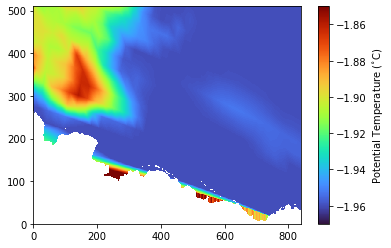

In [21]:
plot_grid = np.ma.masked_where(interpolated_theta[0,:,:]==0, interpolated_theta[0,:,:])
C = plt.pcolormesh(plot_grid,vmin=-1.97, vmax=-1.85, cmap='turbo')
plt.colorbar(C, label='Potential Temperature ($^{\circ}$C)')
plt.show()

Next, for the coastline issue, let's make a land threshold mask to avoid areas which would be wet in the original ECCO grid:

In [22]:
ecco_maskC_on_regional_domain = np.zeros_like(maskC)
for k in range(1):
    ecco_maskC_on_regional_domain[k,:,:] = griddata(utm_coordinates, ecco_maskC_points[k,:], (X, Y), method='nearest')

Let's take a look:

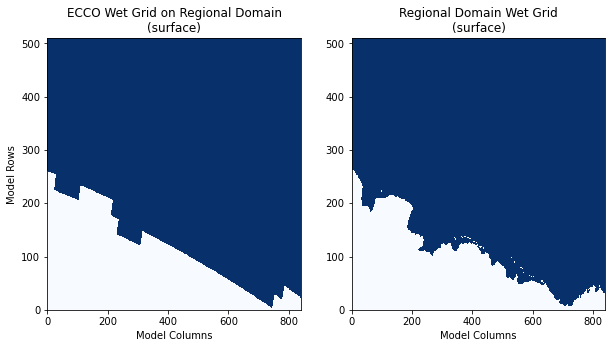

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pcolormesh(ecco_maskC_on_regional_domain[0,:,:], cmap='Blues')
plt.title('ECCO Wet Grid on Regional Domain\n(surface)')
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')

plt.subplot(1,2,2)
plt.pcolormesh(maskC[0,:,:], cmap='Blues')
plt.title('Regional Domain Wet Grid\n(surface)')
plt.xlabel('Model Columns')

plt.show()

As we can see, the coastlines are much different. In addition, if any dry cell from ECCO was counted as a wet cell in the interpolation, this 0 value would cause some interpolation artefacts. To alleviate this potential problem, I will apply one additional buffer from the ECCO coastline equal to half the grid cell size in this area:

In [24]:
threshold = 20e3 # approximate ECCO resolution in this region
for k in range(1):
    level = np.ones_like(ecco_maskC_on_regional_domain[k,:,:])
    for p in range(np.shape(utm_coordinates)[0]):
        if ecco_maskC_points[k,p]==0:
            dist = ((utm_coordinates[p,0]-X)**2 + (utm_coordinates[p,1]-Y)**2)**0.5
            level[dist<threshold] = 0
            ecco_maskC_on_regional_domain[k,:,:] =level

The final mask for the ECCO grid looks as follows:

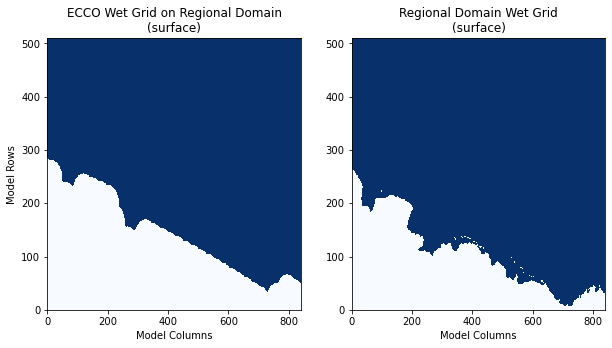

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pcolormesh(ecco_maskC_on_regional_domain[0,:,:], cmap='Blues')
plt.title('ECCO Wet Grid on Regional Domain\n(surface)')
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')

plt.subplot(1,2,2)
plt.pcolormesh(maskC[0,:,:], cmap='Blues')
plt.title('Regional Domain Wet Grid\n(surface)')
plt.xlabel('Model Columns')

plt.show()

With this mask, the coastline values will be more sensibly filled:

In [26]:
interpolated_theta = horizontal.downscale_3D_points(utm_coordinates,
                                                   theta_grid, ecco_maskC_points, 
                                                   X, Y, maskC, ecco_maskC_on_regional_domain,
                                                   testing=True, printing=True)

    Working on level 0 of 50 (338562 nonzero points found)


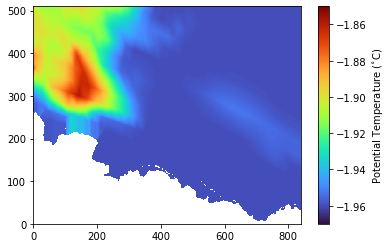

In [27]:
plot_grid = np.ma.masked_where(interpolated_theta[0,:,:]==0, interpolated_theta[0,:,:])
C = plt.pcolormesh(plot_grid,vmin=-1.97, vmax=-1.85, cmap='turbo')
plt.colorbar(C, label='Potential Temperature ($^{\circ}$C)')
plt.show()

### Step 7: Creating the Interpolation Grid 

Finally, with the grid read in, interpolated to the same vertical levels, and reprojected to a sensible coordinate system, we can create our interpolation grid:

In [28]:
gridC, gridS, gridW = \
ecco_interp.create_interpolation_grids(utm_coordinates[:,0], utm_coordinates[:,1],
                           ecco_maskC_points, ecco_maskC_on_regional_domain,
                           X, Y, maskC, maskS, maskW,
                           testing=True, printing=True)

 - Working on level 0 of 81 (338562 nonzero points found)
   - Remaining points before horizontal spread: 32538
   - Remaining points before downward spread: 0
 - Working on level 0 of 81 (337553 nonzero points found)
   - Remaining points before horizontal spread: 31532
   - Remaining points before downward spread: 0
 - Working on level 0 of 81 (338039 nonzero points found)
   - Remaining points before horizontal spread: 32018
   - Remaining points before downward spread: 0


With this grid computed, we can now store it as a netCDF file which can be used later for all of our initial conditions:

In [29]:
interpolation_type_grid_C, source_row_grid_C, source_col_grid_C, source_level_grid_C = gridC
interpolation_type_grid_S, source_row_grid_S, source_col_grid_S, source_level_grid_S = gridS
interpolation_type_grid_W, source_row_grid_W, source_col_grid_W, source_level_grid_W = gridW

In [30]:
output_file = os.path.join(data_folder,'NorthSlope_interpolation_grid.nc')
ecco_interp.write_interpolation_grid_to_nc(output_file,
                                   interpolation_type_grid_C, source_row_grid_C, source_col_grid_C, source_level_grid_C,
                                   interpolation_type_grid_S, source_row_grid_S, source_col_grid_S, source_level_grid_S,
                                   interpolation_type_grid_W, source_row_grid_W, source_col_grid_W, source_level_grid_W)

### Step 8: Visualizing the Interpolation Grid

Now that we've computed our interpolation grid, let's have a peek at the results:

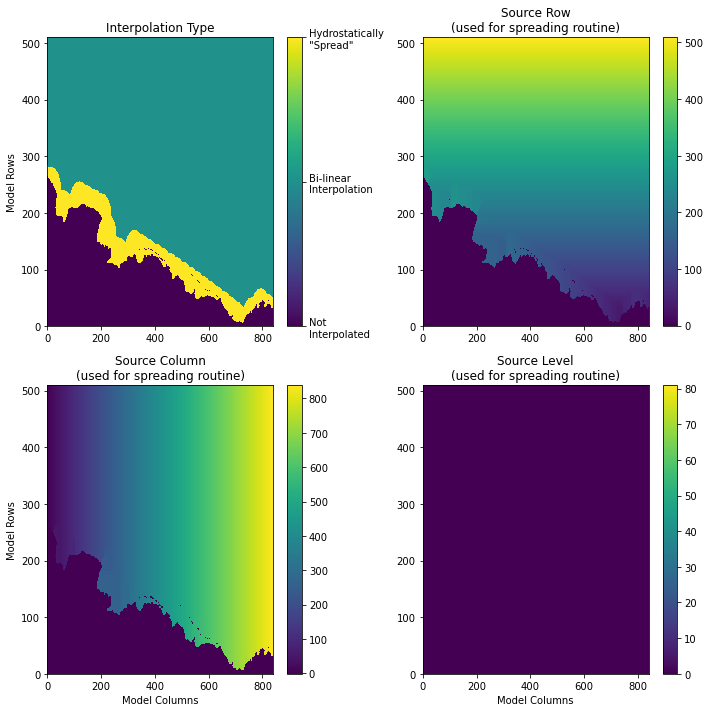

In [31]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
C = plt.pcolormesh(interpolation_type_grid_C[0,:,:])
cbar = plt.colorbar(C)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(['Not\nInterpolated','Bi-linear\nInterpolation','Hydrostatically\n"Spread"'])
plt.ylabel('Model Rows')
plt.title('Interpolation Type')

plt.subplot(2,2,2)
C = plt.pcolormesh(source_row_grid_C[0,:,:])
plt.colorbar(C)
plt.title('Source Row\n(used for spreading routine)')

plt.subplot(2,2,3)
C = plt.pcolormesh(source_col_grid_C[0,:,:])
plt.colorbar(C)
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')
plt.title('Source Column\n(used for spreading routine)')

plt.subplot(2,2,4)
C = plt.pcolormesh(source_level_grid_C[0,:,:],vmin=0,vmax=81)
plt.colorbar(C)
plt.xlabel('Model Columns')
plt.title('Source Level\n(used for spreading routine)')

plt.tight_layout()

plt.show()

As we can see above, most of the cells in the regional domain will be filled by linear interpolation from the ECCO grid. However, in the areas near the coastline that were unresolved in the ECCO model, we fill these regions somehow. The approach taken here is to assume that the grid will be filled hydrostatically. In other words, we assume that the depth levels in the model will have roughly equal density and adjacent grid cells should have the same values. If spreading cannot occur horizontally, such as in the case of local minima in the bathymetry, the spreading is conducted vertically using the grid cell above (hence the source level grid is also stored). In the plot above, the source grid is all 0 since we are at the surface, but this is not true in general.

This spreading routine is fairly expensive (as you will find if you run the cells above) so it useful to only do this one time - and this is the motivation for creating and saving this interpolation grid. Here, the source row, column, and level is stored so that, when spreading is necessary, the source locations are already identified and can be used readily. 

With this interpolation grid in hand, we are ready to make our initial conditions.